<a href="https://colab.research.google.com/github/cincinnatilibrary/collection-analysis/blob/master/reports/holdshelf_by_branch_by_month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHPL - Collection Analysis - **Hold Shelf**
<img src="https://ilsweb.cincinnatilibrary.org/img/CHPL_Brandmark_Primary.png" alt="CHPL" title="CHPL" width="300"/>

Data sources / Documentation:

* https://ilsweb.cincinnatilibrary.org/collection-analysis/

In [1]:
# !pip install -U altair_saver
# !pip install selenium
# !apt-get install chromium-chromedriver

In [2]:
import pandas as pd
import numpy as np
import altair as alt
from urllib.parse import urlencode
from IPython.display import Image
from IPython.display import HTML

In [3]:
# engine = create_engine('sqlite:///file:current.db?mode=rw&uri=true')

# instead of the local db, we'll use the current_collection data set instead ...
# NOTE: the queries change slighly from the local db
chpl_collection_url = 'https://ilsweb.cincinnatilibrary.org/collection-analysis/current_collection'

In [4]:
# Example query:
# find the percent of of items currently checked out from branch location

# NOTE: this query contains a param we can use to select the name of the branch
sql = """\
select
  strftime('%Y-%m', datetime(modified_epoch, 'unixepoch')) as on_holdshelf_month,
  pickup_location_code,
  :branch_name,
  count(DISTINCT hold_id) as count_holds_for_pickup -- hold_id,
from
  holds_shelf
where
  pickup_location_code in (
    select
      location.code
    from
      branch_name
      join branch on branch.id = branch_name.branch_id
      join location on location.branch_code_num = branch.code_num
    where
      branch_name."name" = :branch_name
  )
group by
  1,
  2,
  3
order by
  on_holdshelf_month DESC
"""

branch_name = "Deer Park"

df = pd.read_json(
    chpl_collection_url 
    + '.json?' 
    + urlencode(
        query={
            'sql': sql, 
            'branch_name': branch_name,
            '_shape': 'array'
        }
      )
)

df.head()

,on_holdshelf_month,pickup_location_code,:branch_name,count_holds_for_pickup
0,2022-01,dp,Deer Park,3448
1,2021-12,dp,Deer Park,3895
2,2021-11,dp,Deer Park,3300
3,2021-10,dp,Deer Park,3793
4,2021-09,dp,Deer Park,3681


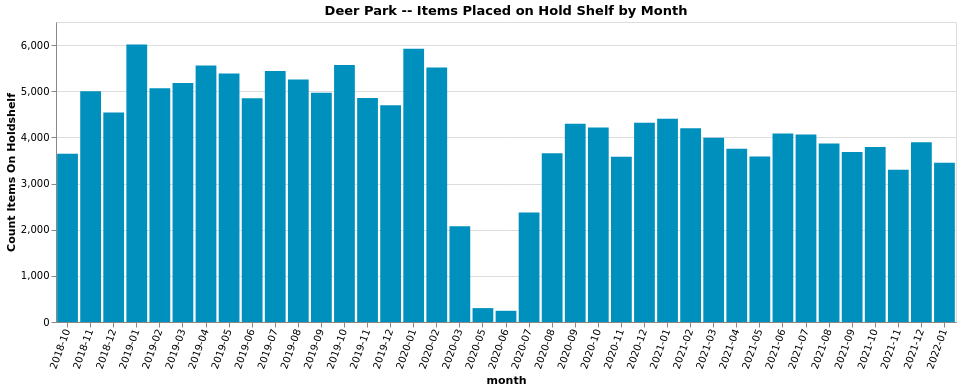

In [5]:
chart = alt.Chart(df).mark_bar(color="#0090bd").encode(
    # x='end_date:T',
    x=alt.X(
        'on_holdshelf_month:O',
        axis=alt.Axis(title='month', labelAngle=-70),
        # sort='-y'
    ),
    y=alt.Y(
        'count_holds_for_pickup:Q',
        title = 'Count Items On Holdshelf',
        # scale = alt.Scale(domain=[0,100]),
    ),
    # tooltip=['branch_name', 'item_format', 'percent_checked_out', 'count_items', 'count_current_checkout', 'sum_checkout_total', 'sum_renewal_total', 'sum_price']
).properties(
    title="{} -- Items Placed on Hold Shelf by Month".format(branch_name),
    width=900,
)

# chart.display()

# we can save this file to an html file: name + date if that's what we want
chart.save(
    'output-{}.html'.format(
        pd.Timestamp('now').strftime('%Y-%m-%d')
    )
)

HTML(filename='output-{}.html'.format(
        pd.Timestamp('now').strftime('%Y-%m-%d')
    )
)

Image('./visualization(77).png')


In [6]:
# for this one, grab the item types, and then also disreguard any small counts (maybe 10 or fewer)
# ... so that our chart isn't too crazy
sql = """\
select
  strftime('%Y-%m', datetime(modified_epoch, 'unixepoch')) as on_holdshelf_month,
  pickup_location_code,
  :branch_name as branch_name,
  item.item_format,
  -- count(item.item_format),
  count(DISTINCT hold_id) as count_holds_for_pickup
from
  holds_shelf
  join item on item.item_record_num = holds_shelf.record_num
where
  pickup_location_code in (
    select
      location.code
    from
      branch_name
      join branch on branch.id = branch_name.branch_id
      join location on location.branch_code_num = branch.code_num
    where
      branch_name."name" = :branch_name
  )
group by
  1,
  2,
  3,
  4
having count(DISTINCT hold_id) >= 10
order by
  on_holdshelf_month DESC
"""

df = pd.read_json(
    chpl_collection_url 
    + '.json?' 
    + urlencode(
        query={
            'sql': sql, 
            'branch_name': branch_name,
            '_shape': 'array'
        }
      )
)

df.head()

,on_holdshelf_month,pickup_location_code,branch_name,item_format,count_holds_for_pickup
0,2022-01,dp,Deer Park,Audio Enabled Juvenile Book,17
1,2022-01,dp,Deer Park,Book,1391
2,2022-01,dp,Deer Park,Book on CD,35
3,2022-01,dp,Deer Park,DVD/Videocassette,465
4,2022-01,dp,Deer Park,Juvenile Book,941


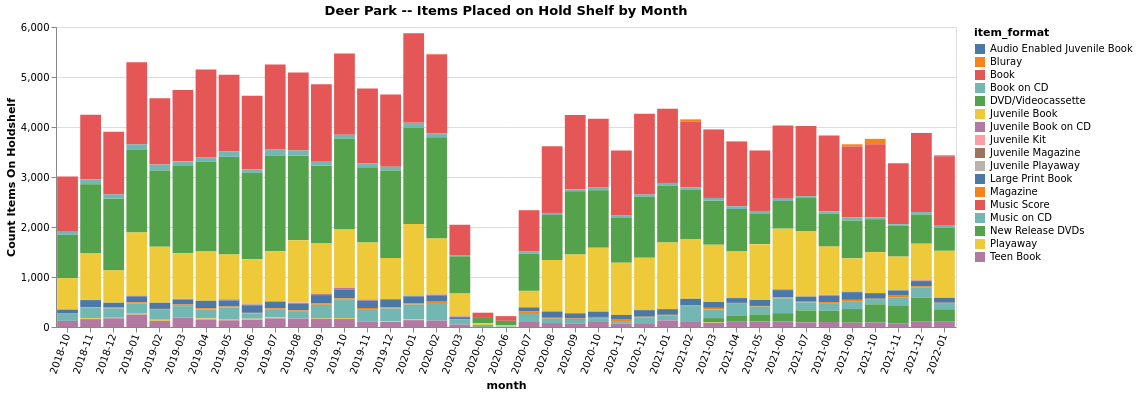

In [7]:
chart = alt.Chart(df).mark_bar().encode(
    # x='end_date:T',
    x=alt.X(
        'on_holdshelf_month:O',
        axis=alt.Axis(title='month', labelAngle=-70),
        # sort='-y'
    ),
    y=alt.Y(
        'count_holds_for_pickup:Q',
        title = 'Count Items On Holdshelf',
        # scale = alt.Scale(domain=[0,100]),
    ),
    color='item_format',
    tooltip=['on_holdshelf_month', 'pickup_location_code', 'branch_name', 'item_format', 'count_holds_for_pickup']
).properties(
    title="{} -- Items Placed on Hold Shelf by Month".format(branch_name),
    width=900,
)

# chart.display()

# we can save this file to an html file: name + date if that's what we want
chart.save(
    'output-2-{}.html'.format(
        pd.Timestamp('now').strftime('%Y-%m-%d')
    )
)

# display 
HTML(filename='output-2-{}.html'.format(
        pd.Timestamp('now').strftime('%Y-%m-%d')
    )
)

Image('./visualization(78).png')